# Rendering a Single Recent True-Color Mosaic

Use the variables below to configure the pipeline output:

In [1]:
from datetime import date, timedelta

In [2]:
# the area you want to create a true color image from; will be the first area returned from nominatim.openstreetmap.com
region_of_interest = 'Berlin, Germany'
# start and end of the time span from which to select satellite data
start_date = date(2020, 7, 1)
end_date = start_date + timedelta(days=31)
# maximum amount of cloud coverage of a single product in order to be considered for the mosaic
max_cloud_cover = 30
# coordinate reference system of the final image
target_crs = 'EPSG:25833'
# should the pixels outside of the region of interest be discarded?
discard_exterior_pixels = False

## Pipeline

All of the code below should not need to be changed.

In [3]:
from sentinelsat import SentinelAPI
from sentinel_helpers import search_osm, plot_all
import datetime
import os

In [4]:
api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))

In [5]:
footprint = search_osm(region_of_interest)
footprint = footprint[footprint['osm_type'] == 'relation'].iloc[:1]
footprint

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
1,256375666,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52..."


In [6]:
convex_hull = footprint.iloc[0]['geometry'].convex_hull.wkt
products = api.query(convex_hull,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0, max_cloud_cover))

How many results do we have?

In [7]:
print('Found ' + str(len(products)) + ' results')

Found 5 results


`products` is a map of product UUID to detailed meta information for each product. This meta information contains scene classification image and more, all if which we can use to further narrow down the products as needed.

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


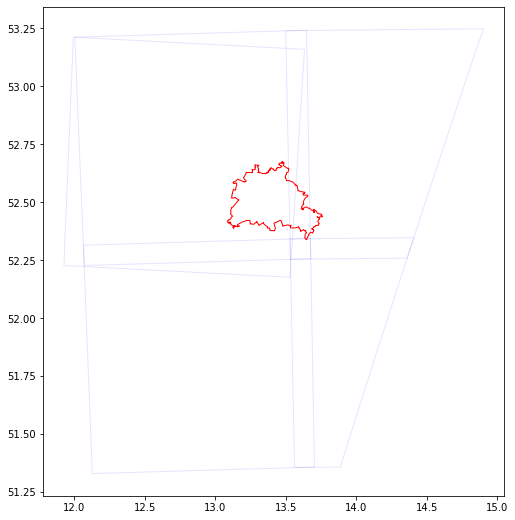

In [8]:
gdf = api.to_geodataframe(products)
plot_all([gdf, footprint],
        [{'color': 'none', 'edgecolor': 'blue', 'alpha': 0.1, 'figsize': (16, 9)},
          {'color': 'none', 'edgecolor': 'red'}])

We want to select the least cloudy products

In [9]:
from tqdm.notebook import tqdm
from sentinel_helpers import scihub_product_ids

In [10]:
gdf = gdf.sort_values(by='cloudcoverpercentage', ascending=False)

In [11]:
geometry = footprint.iloc[0].geometry
for idx, product in tqdm(gdf.iterrows(), total=len(gdf)):
    union = gdf.loc[:idx].unary_union
    if union.contains(geometry):
        break

Note that due to the structure of the loop above, the `tqdm` progress bar will display a number of completed loops that is one less than the number of products included.

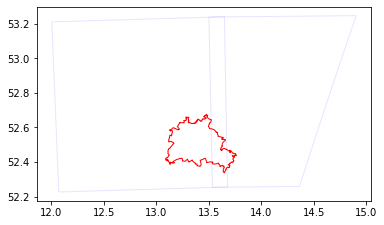

In [12]:
plot_all([gdf.loc[:idx], footprint],
        [{'facecolor': 'none', 'edgecolor': 'blue', 'alpha': 0.1},
        {'facecolor': 'none', 'edgecolor': 'red'}])

Below you can find the products we use to plot the resulting raster file. You can use the table to find out information about the exact capture time.

In [13]:
gdf.loc[:idx]

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,size,s2datatakeid,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,identifier,uuid,geometry
09ca3647-d666-45b8-afab-609dcfd5daf9,S2A_MSIL2A_20200730T102031_N0214_R065_T33UVU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-07-30T10:20:31.024Z, Instrument: MS...",false,2020-07-30 10:20:31.024,2020-07-30 10:20:31.024,2020-07-30 13:31:57.387,26660,...,808.40 MB,GS2A_20200730T102031_026660_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200730T102031_N0214_R065_T33UVU_2...,09ca3647-d666-45b8-afab-609dcfd5daf9,"MULTIPOLYGON (((13.53443 52.25345, 14.36238 52..."
523a8204-74b6-4acc-a5b2-33fb367249a1,S2A_MSIL2A_20200730T102031_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-07-30T10:20:31.024Z, Instrument: MS...",false,2020-07-30 10:20:31.024,2020-07-30 10:20:31.024,2020-07-30 13:31:02.101,26660,...,1.08 GB,GS2A_20200730T102031_026660_N02.14,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_MSIL2A_20200730T102031_N0214_R065_T33UUU_2...,523a8204-74b6-4acc-a5b2-33fb367249a1,"MULTIPOLYGON (((12.07160 52.22621, 13.67854 52..."


In [14]:
subset = scihub_product_ids(gdf.loc[:idx])

We continue by creating the folder structure and initializing the download.

In [15]:
from pathlib import Path

dst_path = Path('input/raster/true_color_pipeline')

In [16]:
! mkdir -p {dst_path}

In [17]:
downloads = api.download_all(subset, dst_path)

## Combine the Downloaded Products

In [18]:
from collections import Counter
import matplotlib.pyplot as pplt
import rasterio as r
from rasterio import plot as rplot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sentinel_helpers import RasterReaderList, scihub_band_paths

%matplotlib inline

In [19]:
downloaded_paths = [d['path'] for d in downloads[0].values()]

In [ ]:
bands = ['B02', 'B03', 'B04']
reprojected_rasters = []

with RasterReaderList(band for product in downloaded_paths for band in scihub_band_paths(product, bands, '10m')) as to_merge:
    for src in tqdm(to_merge, desc='Reprojecting raster files…'):
        # create a temporary file to write the output to
        tmp_path = Path('/tmp/reprojected/') / target_crs / Path(src.name.replace('zip+file://', '').replace('.zip!', ''))
        ! mkdir -p {tmp_path.parent}
        
        # this is mostly taken from https://rasterio.readthedocs.io/en/latest/topics/reproject.html
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with r.open(tmp_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=r.band(src, i),
                    destination=r.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)
            reprojected_rasters.append(tmp_path)

## TODO

- Merge each band individually
- Combine all of the merged products as custom TCI

In [ ]:
from rasterio.merge import merge
from collections import defaultdict

In [ ]:
# we build an index that allows us to access subsets of the raster path list
# above by their band number because we need to merge them separately
grouped_by_band = defaultdict(list)
merged = {}

In [ ]:
import pathlib

In [ ]:
for raster in reprojected_rasters:
    file_name = raster.split('/')[-1] if type(raster) == str else raster.name
    band = file_name.split('_')[-2]
    grouped_by_band[band].append(raster)

In [ ]:
for band, paths in tqdm(grouped_by_band.items(), desc='Merging bands to cover the entire area of interest'):
    with RasterReaderList(paths) as raster_readers:
        mosaic, mosaic_transform = merge(raster_readers)
        merged[band] = mosaic

In [ ]:
import numpy as np

In [ ]:
height, width = merged['B03'][0].shape
kwargs = {
    'count': 3,
    'crs': target_crs,
    'transform': transform,
    'width': width,
    'height': height,
    'transform': mosaic_transform,
    'driver': 'GTiff',
    'dtype': np.uint8
}

In [ ]:
import re

out_name = re.sub(r'[^\w]', '-', region_of_interest).lower()
out_name = 'tci-' + re.sub(r'-+', '-', out_name) + '.tif'

In [ ]:
import numpy as np
from sentinel_helpers import scihub_normalize_range
from rasterio.io import MemoryFile
import rasterio.mask as rmask

In [ ]:
from shapely.geometry import box

In [ ]:
%%time
kwargs = {
    'count': 3,
    'crs': target_crs,
    'transform': transform,
    'width': width,
    'height': height,
    'transform': mosaic_transform,
    'driver': 'GTiff',
    'dtype': np.uint8
}

with MemoryFile() as memfile, memfile.open(**kwargs) as tmp:
    # combine 
    tmp.write((scihub_normalize_range(merged['B04'][0]) * 255).astype(np.uint8), 1)
    tmp.write((scihub_normalize_range(merged['B03'][0]) * 255).astype(np.uint8), 2)
    tmp.write((scihub_normalize_range(merged['B02'][0]) * 255).astype(np.uint8), 3)
    
    mask_shape = footprint.to_crs(target_crs).iloc[0].geometry
    if not discard_exterior_pixels:
        mask_shape = box(*mask_shape.bounds)
    
    masked, masked_transform = rmask.mask(tmp, shapes=[mask_shape], crop=True)
    
    # show the result
    pplt.figure(figsize=(20,20))
    rplot.show(masked, transform=masked_transform)
    
    # save the output
    kwargs.update({
        'transform': masked_transform
    })
    with r.open(out_name, 'w', **kwargs) as dst:
        dst.write(tmp)
        print(f'Wrote resulting raster file to {out_name}!')